In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import json
from os.path import expanduser

In [2]:
experiment_name = 'P3856'
feature_detection_method = 'pasef'

IDENTIFICATIONS_DIR = '{}/identifications-pasef-cs-true-fmdw-true'.format(expanduser("~"))
IDENTIFICATIONS_FILE = '{}/exp-{}-identifications-{}-recalibrated.pkl'.format(IDENTIFICATIONS_DIR, experiment_name, feature_detection_method)

In [3]:
MAXIMUM_Q_VALUE = 0.01

#### identifications with correction for saturation

In [4]:
# load the identifications that had saturated points in the mono
with open(IDENTIFICATIONS_FILE, 'rb') as handle:
    d = pickle.load(handle)
identifications_with_cs_df = d['identifications_df']
identifications_with_cs_df = identifications_with_cs_df[(identifications_with_cs_df['percolator q-value'] <= MAXIMUM_Q_VALUE)]

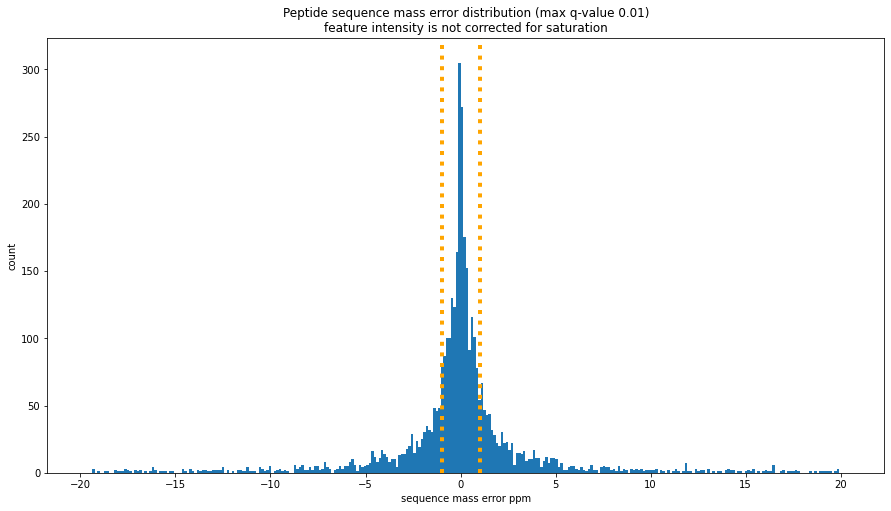

In [5]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide sequence mass error distribution (max q-value {})\nfeature intensity is not corrected for saturation'.format(MAXIMUM_Q_VALUE))

bins = 300
hist, bins, _ = plt.hist(identifications_with_cs_df.mass_accuracy_ppm, bins=bins)
plt.xlabel('sequence mass error ppm')
plt.ylabel('count')

# plt.ylim((0,1200))

plt.axvline(x=+1, linestyle=':', linewidth=4, color='orange')
plt.axvline(x=-1, linestyle=':', linewidth=4, color='orange')

plt.show()

#### identifications without correction for saturation

In [6]:
IDENTIFICATIONS_DIR = '{}/identifications-pasef-cs-false-fmdw-true'.format(expanduser("~"))
IDENTIFICATIONS_FILE = '{}/exp-{}-identifications-{}-recalibrated.pkl'.format(IDENTIFICATIONS_DIR, experiment_name, feature_detection_method)

In [7]:
# load the identifications that had saturated points in the mono
with open(IDENTIFICATIONS_FILE, 'rb') as handle:
    d = pickle.load(handle)
identifications_without_cs_df = d['identifications_df']
identifications_without_cs_df = identifications_without_cs_df[(identifications_without_cs_df['percolator q-value'] <= MAXIMUM_Q_VALUE)]

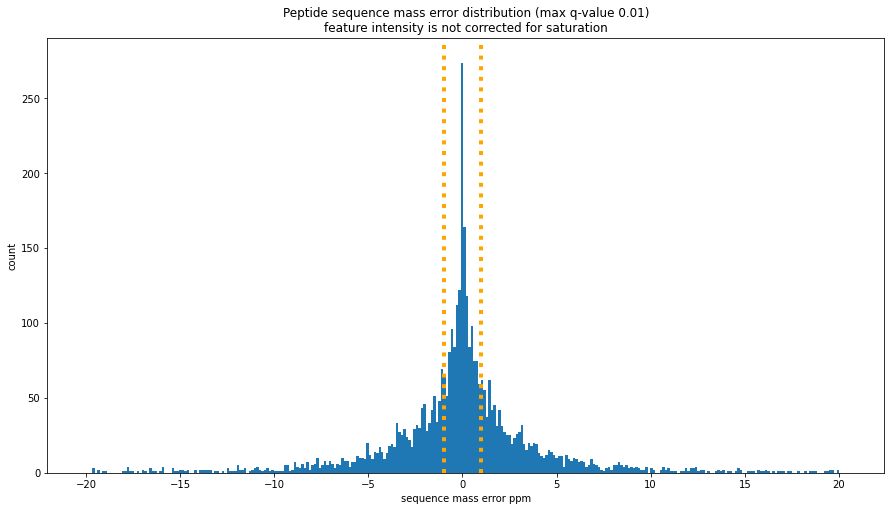

In [8]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide sequence mass error distribution (max q-value {})\nfeature intensity is not corrected for saturation'.format(MAXIMUM_Q_VALUE))

bins = 300
hist, bins, _ = plt.hist(identifications_without_cs_df.mass_accuracy_ppm, bins=bins)
plt.xlabel('sequence mass error ppm')
plt.ylabel('count')

# plt.ylim((0,1200))

plt.axvline(x=+1, linestyle=':', linewidth=4, color='orange')
plt.axvline(x=-1, linestyle=':', linewidth=4, color='orange')

plt.show()

#### unique identifications found with and without saturation correction

In [134]:
sequences_l = []
for group_name,group_df in identifications_with_cs_df.groupby(['sequence','charge'], as_index=False):
    sequence = group_name[0]
    charge = group_name[1]
    percolator_score = group_df['percolator score'].max()
    q_value = group_df['percolator q-value'].min()
    sequences_l.append({'sequence':sequence, 'charge':charge, 'score':percolator_score, 'q_value':q_value})
sequences_with_cs_df = pd.DataFrame(sequences_l)

In [135]:
sequences_l = []
for group_name,group_df in identifications_without_cs_df.groupby(['sequence','charge'], as_index=False):
    sequence = group_name[0]
    charge = group_name[1]
    percolator_score = group_df['percolator score'].max()
    q_value = group_df['percolator q-value'].min()
    sequences_l.append({'sequence':sequence, 'charge':charge, 'score':percolator_score, 'q_value':q_value})
sequences_without_cs_df = pd.DataFrame(sequences_l)

In [136]:
combined_df = pd.merge(sequences_with_cs_df, sequences_without_cs_df, how='inner', left_on=['sequence','charge'], right_on=['sequence','charge'], suffixes=['_with_cs','_without_cs'])


In [148]:
combined_df['q_value_ratio'] = combined_df.q_value_with_cs / combined_df.q_value_without_cs
combined_df['score_ratio'] = combined_df.score_with_cs / combined_df.score_without_cs

In [151]:
combined_df.sample(n=5)

,sequence,charge,score_with_cs,q_value_with_cs,score_without_cs,q_value_without_cs,q_value_ratio,score_ratio
2751,VISLEINHQPVQEVK,2,0.596428,0.000704,0.527507,0.000650,1.082365,1.130655
1418,KPTDGASSSNCVTDISHLVR,2,0.358718,0.000970,0.352513,0.000650,1.490789,1.017602
1827,MTAEKPDPTLAVICGAATK,2,0.408206,0.000704,0.360958,0.000650,1.082365,1.130896
1184,HYQDVSCLQFTGDSSHFISGGK,3,1.185525,0.000588,1.088406,0.000507,1.159906,1.089231
2853,VVAQVEDAVNNTQQADLK,2,1.107959,0.000588,0.949158,0.000507,1.159906,1.167307


In [153]:
combined_df.loc[combined_df.score_ratio.idxmax()]

sequence              AGNWPGSPQVSGPSPAARM[15.9949]PGMSPANPSLHSPVPDAS...
charge                                                                4
score_with_cs                                                  0.183652
q_value_with_cs                                              0.00201034
score_without_cs                                             0.00376475
q_value_without_cs                                            0.0084455
q_value_ratio                                                  0.238037
score_ratio                                                      48.782
Name: 81, dtype: object

#### compare identification score with and without

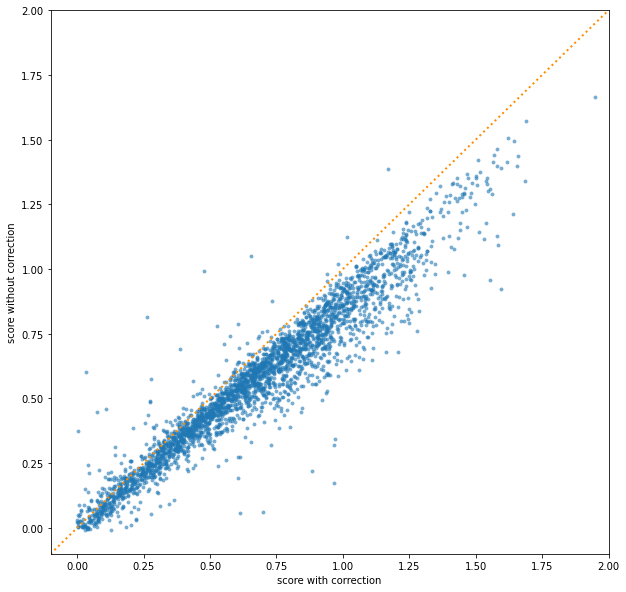

In [137]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

plt.margins(0.06)
plt.title('')

ax.scatter(combined_df.score_with_cs, combined_df.score_without_cs, marker='o', lw=0, s=15, alpha=0.6)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle=':', linewidth=2, color='darkorange')

plt.xlim((-0.1,2.0))
plt.ylim((-0.1,2.0))

plt.xlabel('score with correction')
plt.ylabel('score without correction')

plt.show()

#### compare identification q-value with and without

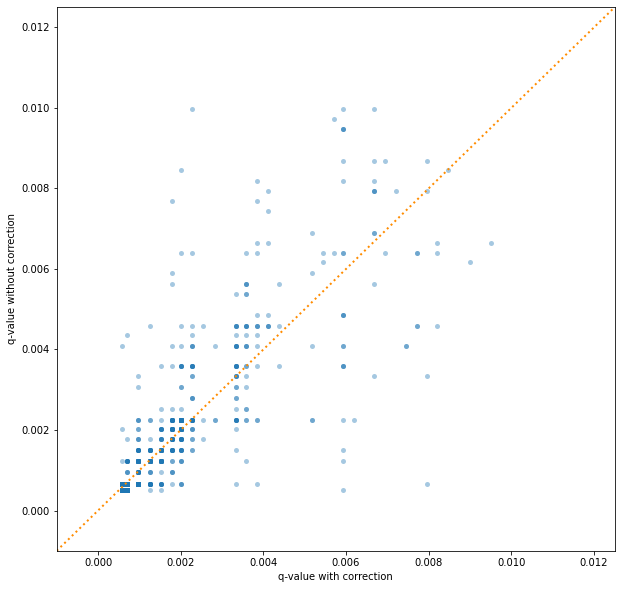

In [155]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

plt.margins(0.06)
plt.title('')

ax.scatter(combined_df.q_value_with_cs, combined_df.q_value_without_cs, marker='o', lw=0, s=25, alpha=0.4)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle=':', linewidth=2, color='darkorange')

plt.xlim((-0.001,0.0125))
plt.ylim((-0.001,0.0125))

plt.xlabel('q-value with correction')
plt.ylabel('q-value without correction')

plt.show()

#### dynamic range comparison

In [77]:
s1 = identifications_with_cs_df.mono_intensity_adjustment_outcome.value_counts(normalize=False).rename('counts', inplace=True)
s2 = round(identifications_with_cs_df.mono_intensity_adjustment_outcome.value_counts(normalize=True)*100,1).rename('%', inplace=True)
pd.concat([s1, s2], axis=1)

,counts,%
monoisotopic_not_saturated,3516,93.5
monoisotopic_saturated_adjusted,240,6.4
no_nonsaturated_isotopes,5,0.1


In [66]:
identifications_with_cs_df = identifications_with_cs_df.copy()
identifications_with_cs_df['intensity_log'] = np.log10(identifications_with_cs_df.feature_intensity)

identifications_without_cs_df = identifications_without_cs_df.copy()
identifications_without_cs_df['intensity_log'] = np.log10(identifications_without_cs_df.feature_intensity)

identifications_with_cs_df['method'] = 'corrected for saturation'
identifications_without_cs_df['method'] = 'not corrected for saturation'
idents_df = pd.concat([identifications_with_cs_df,identifications_without_cs_df], axis=0, sort=False)


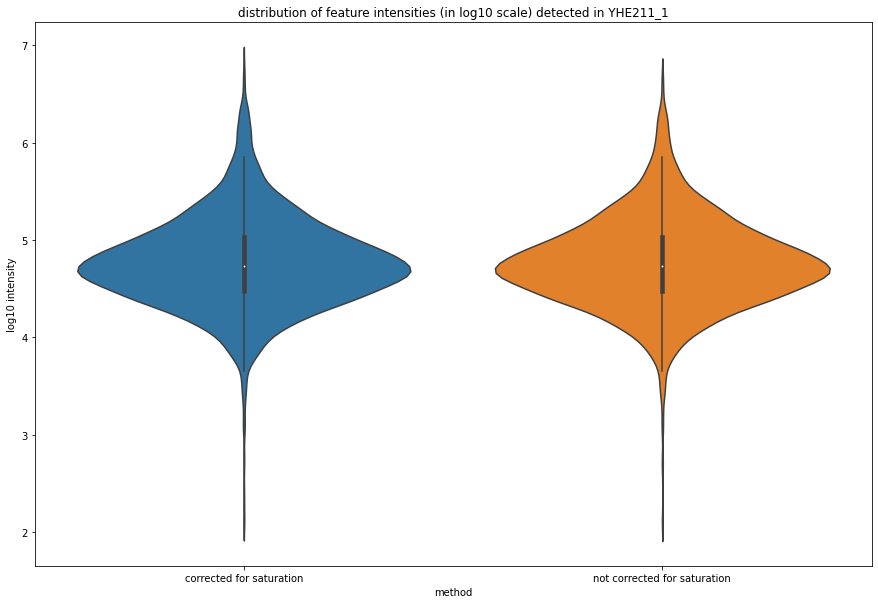

In [67]:
plt.figure(figsize=(15,10))
ax = sns.violinplot(x=idents_df.method, y=idents_df.intensity_log)
_ = plt.ylabel("log10 intensity")
_ = plt.title('distribution of feature intensities (in log10 scale) detected in YHE211_1')

In [69]:
dynamic_range_with_cs = identifications_with_cs_df.intensity_log.max() - identifications_with_cs_df.intensity_log.min()
dynamic_range_without_cs = identifications_without_cs_df.intensity_log.max() - identifications_without_cs_df.intensity_log.min()
print('orders of magnitude with cs: {}, without cs: {}'.format(round(dynamic_range_with_cs,1), round(dynamic_range_without_cs,1)))

orders of magnitude with cs: 4.7, without cs: 4.6


#### for those identifications with an adjusted intensity, what would the intensity range have been without correction?

In [52]:
adj_with_cs_df = identifications_with_cs_df[identifications_with_cs_df.mono_intensity_adjustment_outcome == 'monoisotopic_saturated_adjusted']


In [53]:
adj_l = []
for row in adj_with_cs_df.itertuples():
    adj_l.append({'feature_intensity':row.mono_intensity_with_saturation_correction, 'method':'corrected'})
    adj_l.append({'feature_intensity':row.mono_intensity_without_saturation_correction, 'method':'not corrected'})
adj_df = pd.DataFrame(adj_l)
adj_df['intensity_log'] = np.log10(adj_df.feature_intensity)

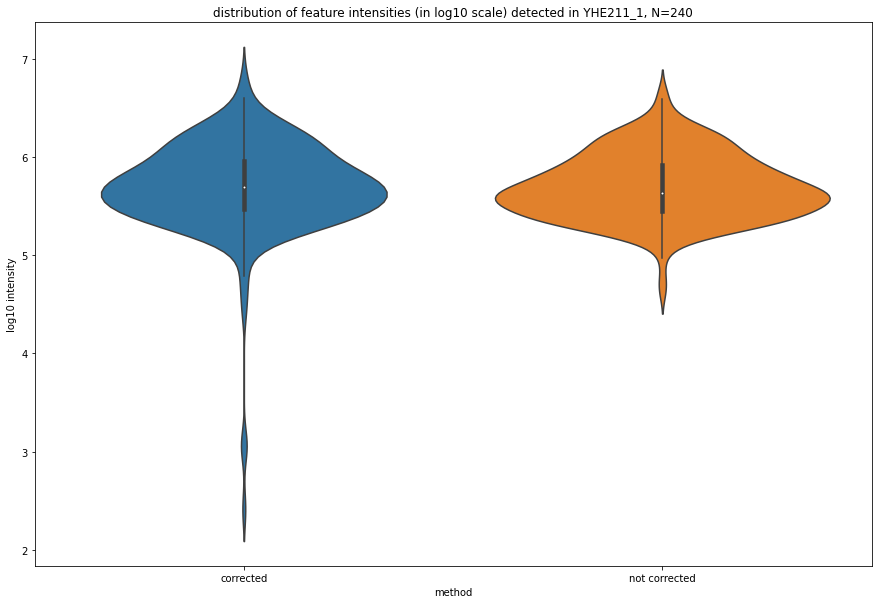

In [54]:
plt.figure(figsize=(15,10))
ax = sns.violinplot(x=adj_df.method, y=adj_df.intensity_log)
_ = plt.ylabel("log10 intensity")
_ = plt.title('distribution of feature intensities (in log10 scale) detected in YHE211_1, N={}'.format(len(adj_with_cs_df)))

#### which isotope was used as a reference for intensity?

In [55]:
isotope_idxs_l = []
for row in adj_with_cs_df.itertuples():
    isotopes_df = pd.DataFrame(row.isotopic_peaks)
    nonsat_isotope_idx = isotopes_df[isotopes_df.inferred == False].iloc[0].name
    isotope_idxs_l.append({'isotope_idx_not_in_saturation':nonsat_isotope_idx})
isotope_idxs_df = pd.DataFrame(isotope_idxs_l)

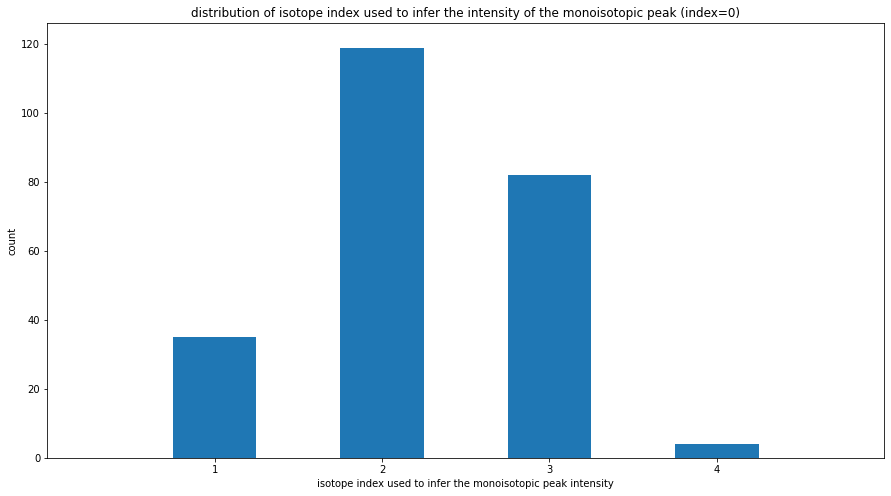

In [56]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

counts = np.bincount(isotope_idxs_df.isotope_idx_not_in_saturation)
ax1.bar(range(isotope_idxs_df.isotope_idx_not_in_saturation.max()+1), counts, width=0.5, align='center')
ax1.set(xticks=range(1,isotope_idxs_df.isotope_idx_not_in_saturation.max()+1), xlim=[0, isotope_idxs_df.isotope_idx_not_in_saturation.max()+1])

plt.xlabel('isotope index used to infer the monoisotopic peak intensity')
plt.ylabel('count')
plt.title('distribution of isotope index used to infer the intensity of the monoisotopic peak (index=0)')

plt.show()

#### of the features that were downgraded, which isotope was used as a reference?

In [63]:
# which sequences had their intensity adjusted down?
downgraded_df = identifications_with_cs_df[(identifications_with_cs_df.mono_intensity_with_saturation_correction < identifications_with_cs_df.mono_intensity_without_saturation_correction)]


In [64]:
isotope_idxs_l = []
for row in downgraded_df.itertuples():
    isotopes_df = pd.DataFrame(row.isotopic_peaks)
    nonsat_isotope_idx = isotopes_df[isotopes_df.inferred == False].iloc[0].name
    isotope_idxs_l.append({'isotope_idx_not_in_saturation':nonsat_isotope_idx})
isotope_idxs_df = pd.DataFrame(isotope_idxs_l)

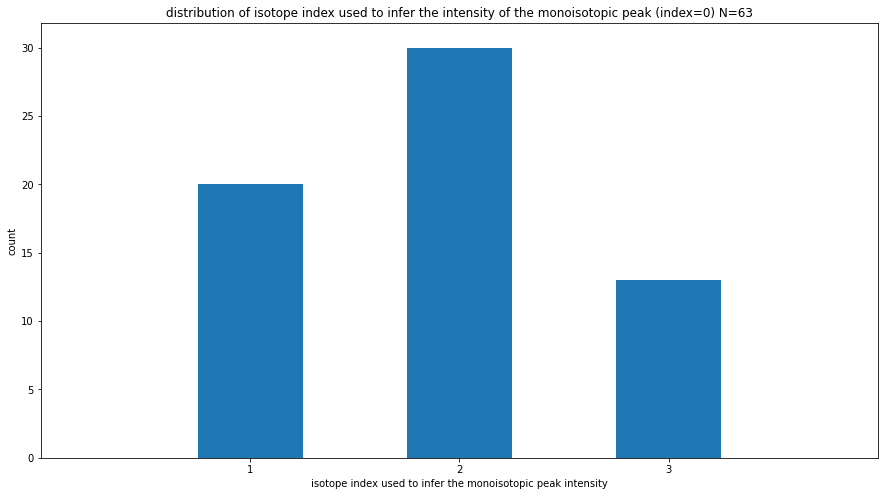

In [65]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

counts = np.bincount(isotope_idxs_df.isotope_idx_not_in_saturation)
ax1.bar(range(isotope_idxs_df.isotope_idx_not_in_saturation.max()+1), counts, width=0.5, align='center')
ax1.set(xticks=range(1,isotope_idxs_df.isotope_idx_not_in_saturation.max()+1), xlim=[0, isotope_idxs_df.isotope_idx_not_in_saturation.max()+1])

plt.xlabel('isotope index used to infer the monoisotopic peak intensity')
plt.ylabel('count')
plt.title('distribution of isotope index used to infer the intensity of the monoisotopic peak (index=0) N={}'.format(len(downgraded_df)))

plt.show()

#### comparing quantisation effect

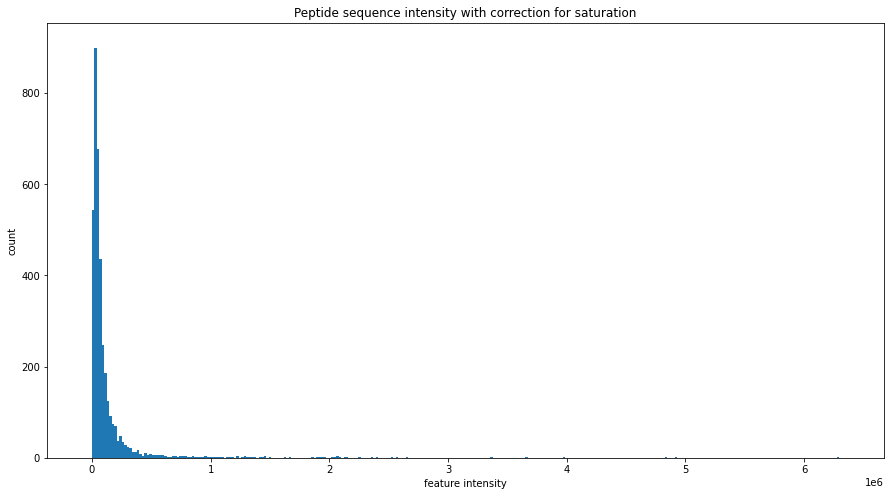

In [79]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide sequence intensity with correction for saturation')

bins = 300
hist, bins, _ = plt.hist(identifications_with_cs_df.feature_intensity, bins=bins)
plt.xlabel('feature intensity')
plt.ylabel('count')

# plt.ylim((0,1200))

plt.show()

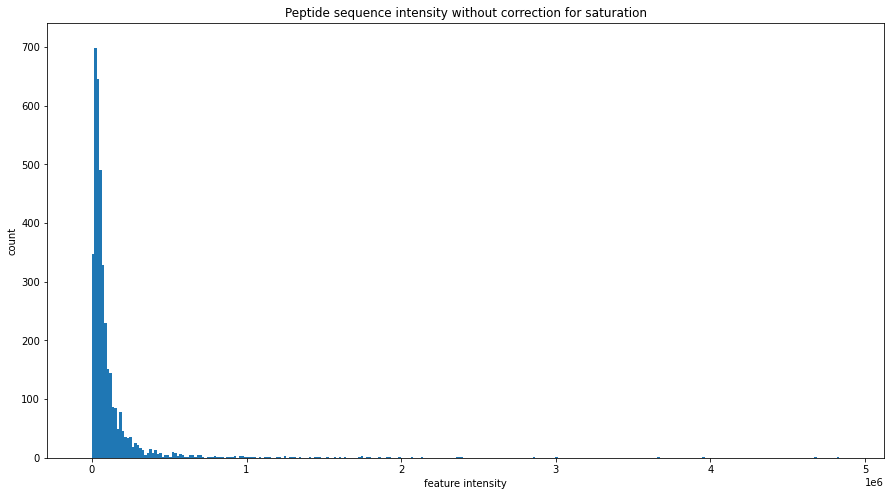

In [81]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide sequence intensity without correction for saturation')

bins = 300
hist, bins, _ = plt.hist(identifications_without_cs_df.feature_intensity, bins=bins)
plt.xlabel('feature intensity')
plt.ylabel('count')

# plt.ylim((0,1200))

plt.show()

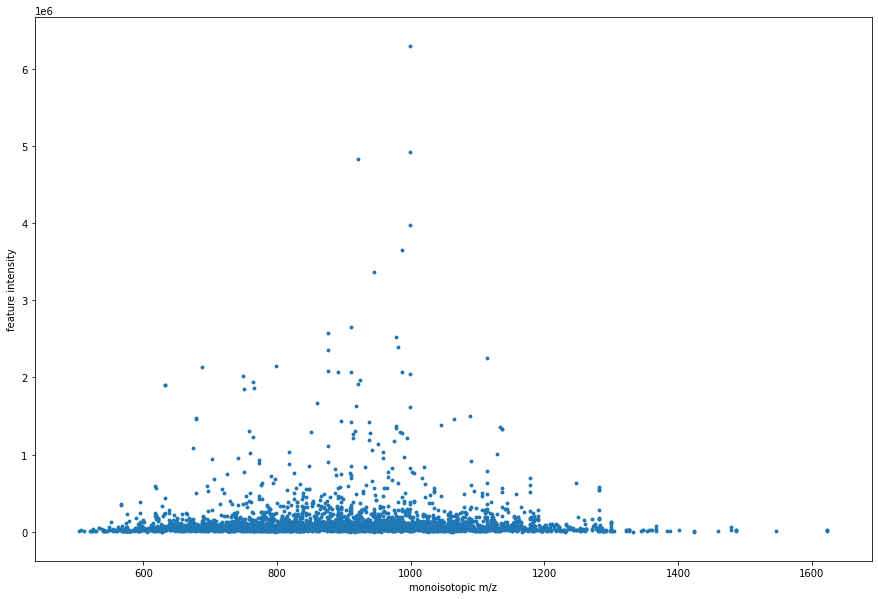

In [86]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

ax.scatter(identifications_with_cs_df.monoisotopic_mz, identifications_with_cs_df.feature_intensity, marker='o', lw=0, s=15, alpha=1.0)

plt.xlabel('monoisotopic m/z')
plt.ylabel('feature intensity')

plt.show()

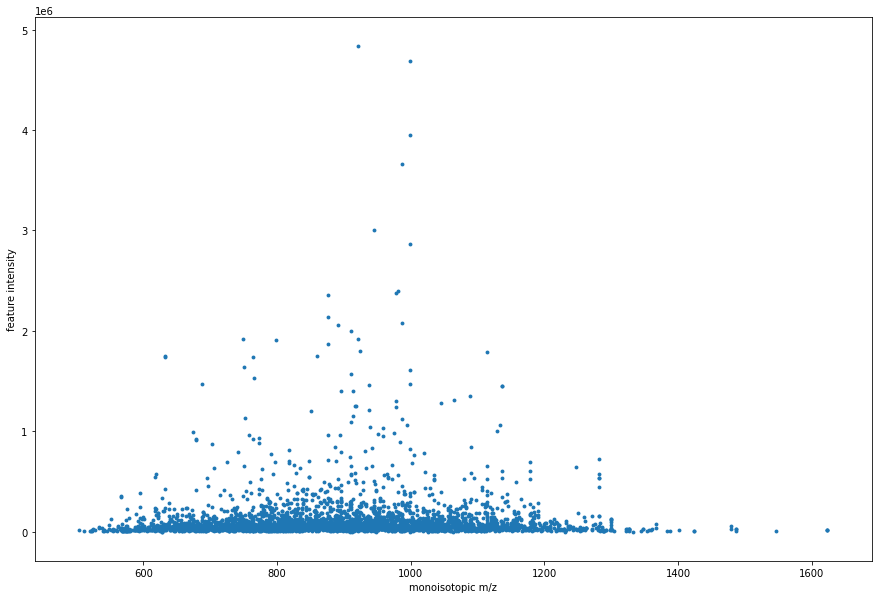

In [87]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

ax.scatter(identifications_without_cs_df.monoisotopic_mz, identifications_without_cs_df.feature_intensity, marker='o', lw=0, s=15, alpha=1.0)

plt.xlabel('monoisotopic m/z')
plt.ylabel('feature intensity')

plt.show()

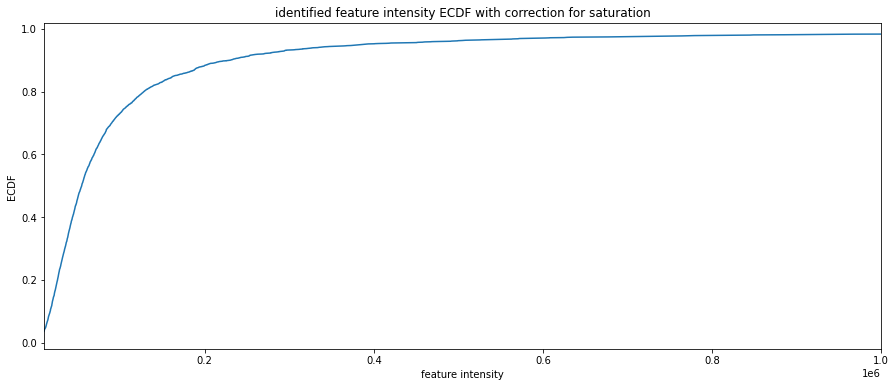

In [93]:
# determine the best clipping value using an ECDF

import statsmodels.api as sm
ecdf = sm.distributions.ECDF(identifications_with_cs_df.feature_intensity)

f, ax1 = plt.subplots()
plt.plot(ecdf.x, ecdf.y)
f.set_figheight(6)
f.set_figwidth(15)
plt.xlabel('feature intensity')
plt.ylabel('ECDF')

plt.xlim((10000,1000000))

plt.margins(0.02)
plt.title("identified feature intensity ECDF with correction for saturation")
plt.show()

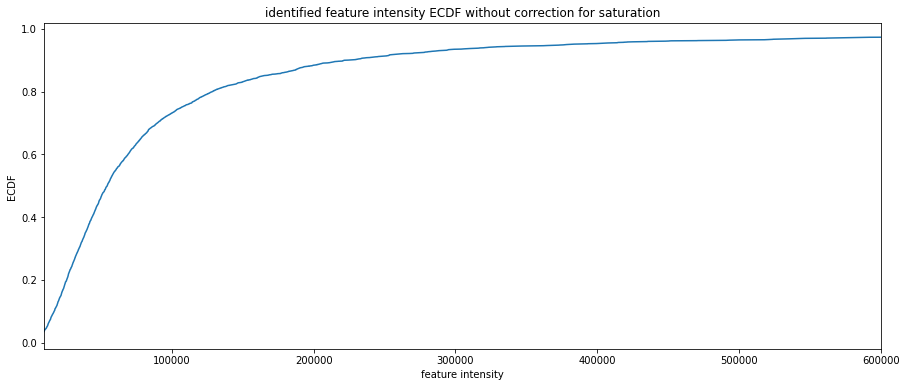

In [98]:
# determine the best clipping value using an ECDF

import statsmodels.api as sm
ecdf = sm.distributions.ECDF(identifications_without_cs_df.feature_intensity)

f, ax1 = plt.subplots()
plt.plot(ecdf.x, ecdf.y)
f.set_figheight(6)
f.set_figwidth(15)
plt.xlabel('feature intensity')
plt.ylabel('ECDF')

plt.xlim((10000,600000))

plt.margins(0.02)
plt.title("identified feature intensity ECDF without correction for saturation")
plt.show()